In [5]:
%pip install pywavelets

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------------ --------------------------- 1.3/4.3 MB 6.7 MB/s eta 0:00:01
   ------------------------ --------------- 2.6/4.3 MB 7.2 MB/s eta 0:00:01
   ------------------------------------ --- 3.9/4.3 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from gua_functions import *
from gua_enums import *
import InteractiveLegend 
import scipy
import scipy.interpolate

Format DF to make features easily

In [2]:
df = pd.read_pickle('combined_all.pkl')

In [3]:
pruned = df[df.index.get_level_values('uid') !='90008']
pruned = pruned[pruned.index.get_level_values('uid') !='90009']

In [4]:
print(df.shape)
print(pruned.shape)

(2976, 10)
(2976, 10)


In [ ]:


def interpolate_sensor_data(record, runup, length_sec, num_samples):
    """Interpolate the sensor data to have the same length for all sensors"""
    flpIndex = flp(record['sensordata.GRV'], record['timestamp.GRV'])
    startTs = max(record['timestamp.GRV'][flpIndex] - int(runup * 10**9),0)
    endTs = startTs + int(length_sec * 10**9)
    for stype in SensorEnum.valid():
        mask = (record['timestamp.'+stype.name] >= startTs) & (record['timestamp.'+stype.name] <= endTs)
        record['sensordata.'+stype.name] = record['sensordata.'+stype.name][mask]
        record['timestamp.'+stype.name] = record['timestamp.'+stype.name][mask]      

        if len(record['timestamp.'+stype.name]) == 0:
            record['timestamp.'+stype.name] = None
            continue

        interp_t = np.linspace(startTs, endTs, num=num_samples)

        interp_func_t = scipy.interpolate.interp1d(record['timestamp.'+stype.name], record['timestamp.'+stype.name], kind='linear', fill_value='extrapolate')
        interp_func_v = scipy.interpolate.interp1d(record['timestamp.'+stype.name], record['sensordata.'+stype.name], axis=0, kind='linear', fill_value='extrapolate')

        record['timestamp.'+stype.name] = interp_func_t(interp_t)
        record['sensordata.'+stype.name] = interp_func_v(interp_t)
    return record
def calculate_duration(row):
    timestamps = row['timestamp.GYR']
    duration = (timestamps[-1] - timestamps[0]) * 1e-9  # Convert from nanoseconds to seconds
    return duration

In [52]:
df_reset = pruned.reset_index(drop=True)
df_reset = df_reset[df_reset['timeoutFlag']==False]
df_reset = df_reset[df_reset['samplerate']==SamplingRateEnum.FASTEST]
df_reset = df_reset[df_reset['stype']!=SensorEnum.LGT]
df_reset = df_reset[df_reset['stype']!=SensorEnum.PRX]
df_reset = df_reset[df_reset['stype']!=SensorEnum.LCC]
df_reset = df_reset[df_reset['timestamp'].apply(lambda x: len(x) > 100)]

print(df_reset['uid'].value_counts())

df_pivot_sensordata = df_reset.pivot_table(index=['uid', 'mid', 'counter'], columns='stype', values='sensordata', aggfunc='first')
df_pivot_timestamp = df_reset.pivot_table(index=['uid', 'mid', 'counter'], columns='stype', values='timestamp', aggfunc='first')
df_pivot_sensordata.rename(columns=lambda x: 'sensordata.'+x.name, inplace=True)
df_pivot_timestamp.rename(columns=lambda x: 'timestamp.'+x.name, inplace=True)
for indx, row in df_pivot_timestamp.iterrows():
    for sn in SensorEnum.valid():
        if isinstance(row['timestamp.'+sn.name], float) :
            row['timestamp.'+sn.name] = None
        elif row['timestamp.'+sn.name][-1]-row['timestamp.'+sn.name][0] < 1 * 1000000000:
            row['timestamp.'+sn.name] = None
        elif len(row['timestamp.'+sn.name]) < 10:
            print('Dropping', indx, sn.name)
            row['timestamp.'+sn.name] = None

df_merged = pd.concat([df_pivot_sensordata, df_pivot_timestamp], axis=1)
df_merged.reset_index(inplace=True)
df_merged = df_merged.dropna(how='any')



df_stripped_interp = df_merged.apply(lambda record: interpolate_sensor_data(record,0.2,4,800), axis=1)
dataFrame = df_stripped_interp.dropna().copy()
dataFrame['duration'] = dataFrame.apply(calculate_duration, axis=1)
dataFrame = dataFrame.drop(columns=['mid', 'counter'])
dataFrame = dataFrame.drop(columns= [x for x in dataFrame.columns if 'timestamp.' in x])
dataFrame.to_pickle('combined_all_interpol_synced_4sec_800samples_prot4.pkl', protocol=4)
print(df_stripped_interp['uid'].value_counts())
#df_stripped_interp.to_pickle('combined_all_interpol_synced.pkl')


#df_merged.to_pickle('combined_formatted.pkl')
df_stripped = df_merged.apply(lambda row: strip_front(row, 0.1), axis=1)
df_stripped.dropna(inplace=True,ignore_index=False)
print(df_stripped['uid'].value_counts())



#df_stripped.to_pickle('combined_all_stripped.pkl')

uid
0112     260
0113     255
0114     255
90006    170
90004    159
90002    145
90005    134
90001    100
90003     95
90007     75
90010     55
Name: count, dtype: int64
uid
0112     52
0113     51
0114     51
90006    34
90004    31
90002    29
90005    26
90001    20
90003    19
90007    15
90010    11
Name: count, dtype: int64
stype
uid                                                            0112
mid                                                               0
counter                                                           0
sensordata.ACC    [[0.05742774, 0.20997019, 9.789636], [0.033499...
sensordata.GYR    [[-0.00015271631, -0.0009162979, -0.0001527163...
sensordata.GRV    [[0.03569325, 0.19156031, 9.808065], [0.035665...
sensordata.MAG    [[0.0732, -19.032, -39.4792], [-0.0122, -18.38...
sensordata.ROT    [[0.0018228985, 0.009812054, 0.9999495, 0.0011...
timestamp.ACC     [429362611480274, 429362613676183, 42936261596...
timestamp.GYR     [429362695429920, 42936269769

In [57]:
dataFrame.iloc[0]['sensordata.ACC']

array([[ 1.14093132e-02,  2.53450552e-01,  9.79272965e+00],
       [ 2.57869113e-02,  2.13901942e-01,  9.81170528e+00],
       [ 2.34705842e-02,  1.92270276e-01,  9.77907920e+00],
       ...,
       [-3.14193786e+00,  5.15217883e+00,  1.24229089e+01],
       [-3.16309397e+00,  5.14292267e+00,  1.24546432e+01],
       [-3.18425007e+00,  5.13366650e+00,  1.24863776e+01]])

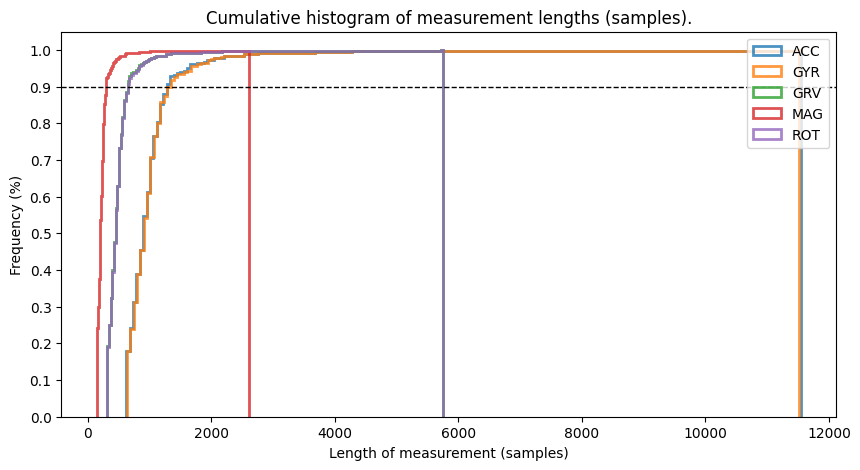

Text(0.5, 0, 'Length of measurement (seconds)')

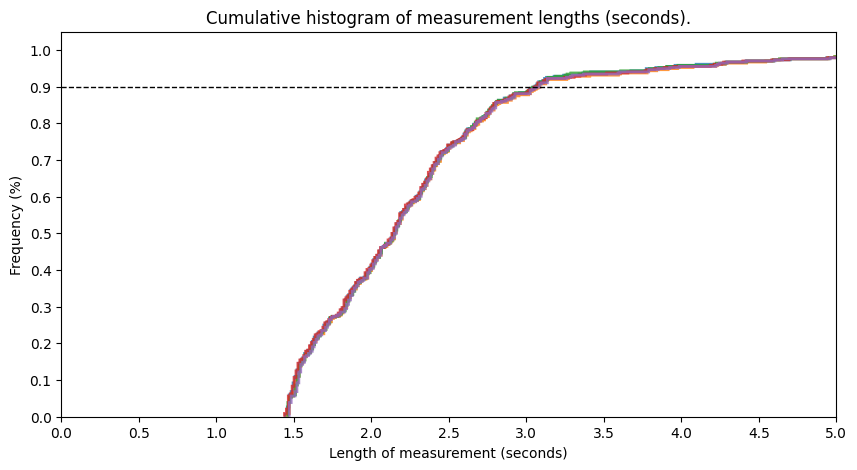

In [51]:
from matplotlib.ticker import MultipleLocator
fig=plt.figure(figsize=(10, 5))
#plt.xlim(0, 4000)
for sensor in SensorEnum.valid():
    lens = df_stripped['timestamp.'+sensor.name].apply(len)
    plt.hist(lens, bins=200, alpha=0.8, label=sensor.name,histtype='step',density= True, cumulative=True, linewidth=2)

plt.axhline(y=0.90, color='k', linestyle='--', linewidth=1)
plt.ylabel('Frequency (%)')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Cumulative histogram of measurement lengths (samples).')
plt.xlabel('Length of measurement (samples)')
plt.legend(loc='upper right')
plt.show()

### plot the histogram of measurement lengths in seconds
fig=plt.figure(figsize=(10, 5))
plt.xlim(0, 5)
for sensor in SensorEnum.valid():
    lens = df_stripped['timestamp.'+sensor.name].apply(lambda x: (x[-1]-x[0])/1000000000)
    plt.hist(lens, bins=2000, alpha=0.8, label=sensor.name,histtype='step',cumulative=True,density=True, linewidth=2)
plt.axhline(y=0.90, color='k', linestyle='--', linewidth=1)

plt.ylabel('Frequency (%)')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 5.1, step=0.5))

plt.title('Cumulative histogram of measurement lengths (seconds).')
plt.xlabel('Length of measurement (seconds)')



In [160]:
from scipy.interpolate import interp1d
def interpolate_to_500_samples(data):
    original_length = data.shape[0]
    x_original = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, 500)
    interpolated_data = interp1d(x_original, data, axis=0)(x_new)
    return interpolated_data

# Apply the interpolation function to each relevant column
for col in df_stripped.columns:
    if 'sensordata' in col or 'timestamp' in col:
        df_stripped[col] = df_stripped[col].apply((lambda x: interpolate_to_500_samples(x)))

# Verify the change
print(df_stripped['sensordata.GRV'].iloc[0].shape)  # Should print (500, 3)
print(df_stripped['timestamp.GRV'].iloc[0].shape)   # Should print (500,)

(500, 3)
(500,)


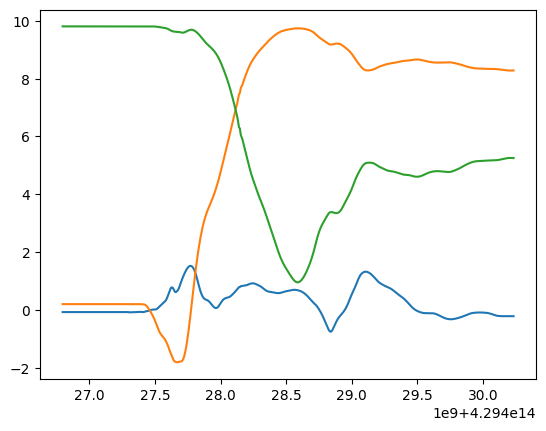

In [161]:
pl = plt.plot(df_stripped['timestamp.GRV'].iloc[1], df_stripped['sensordata.GRV'].iloc[1])

In [162]:
df_stripped.to_pickle('combined_stripped_interpol_500.pkl')

In [5]:
%matplotlib widget

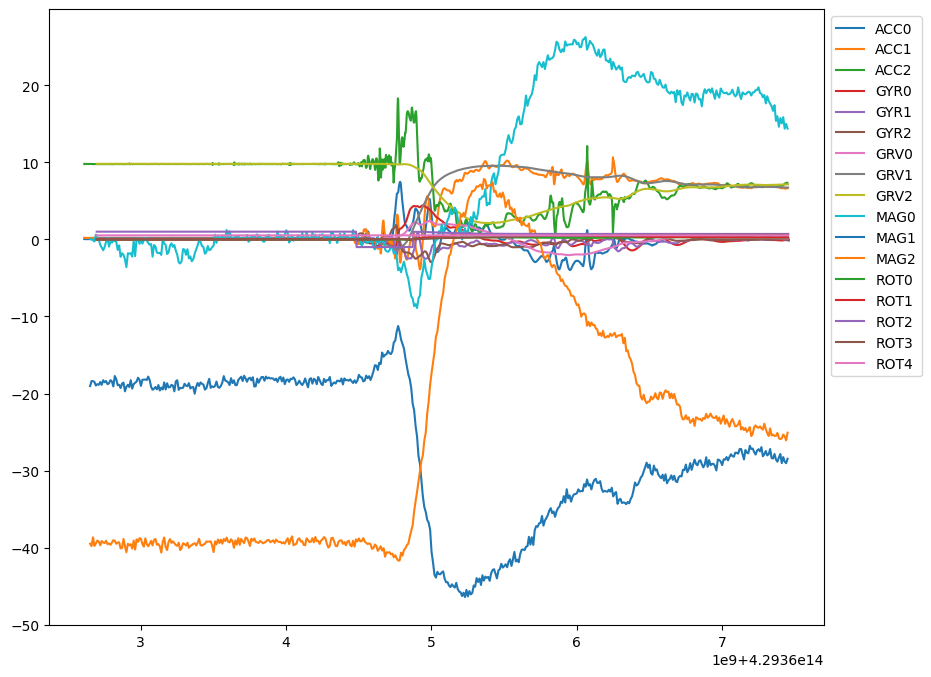

In [16]:
row = df_merged.iloc[0]

figure = plt.figure(figsize=(10,8))
for st in SensorEnum.valid():
    for i in range(0,st.dim()):
        plt.plot(row['timestamp.'+st.name], row['sensordata.'+st.name][:,i], label=st.name + str(i))[0]
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')    
leg = InteractiveLegend.InteractiveLegend() 
plt.show()

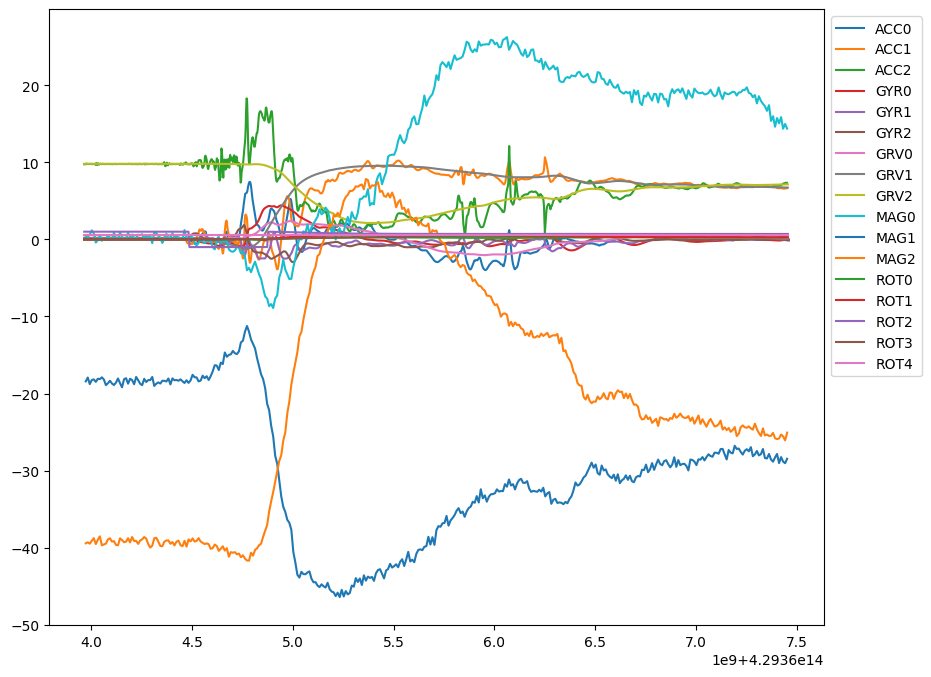

In [17]:
row = df_stripped.iloc[0]
figure = plt.figure(figsize=(10,8))
lines = []
for st in SensorEnum.valid():
    for i in range(0,st.dim()):
        plt.plot(row['timestamp.'+st.name], row['sensordata.'+st.name][:,i], label=st.name + str(i))[0]
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
leg = InteractiveLegend.InteractiveLegend()  # mandatory: keep the object with leg = ...; else it won't work
plt.show()